In [2]:
from score_models import ScoreModel
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from torch.func import vmap, grad 
from tqdm import tqdm
import sys
sys.path.append("../models/")
from gridding import ft, ift 
from posterior_sampling import *
plt.style.use("dark_background")

device  = "cuda" if torch.cuda.is_available() else "cpu"

def probes_link_function(x):
    return link_function(x, C=1/2, B=1/2)

In [3]:
# Loading the weights for a score model trained on a prior: 
score_model = ScoreModel(checkpoints_directory = "../../score_models/ncsnpp_probes_g_64_230604024652/")

Using the Variance Exploding SDE


In [38]:
data_path = "../../../data/"
prior_samples = torch.load(data_path + "probes_prior_samples.pt")
S = torch.tensor(np.load(data_path + "\data_htlup\sampling_function3.npy"))[:256**2].reshape(256, 256).to(device)

In [23]:
sample = prior_samples[0, 0]
padded_sample = torch.nn.functional.pad(prior_samples[0,0], [96, 96, 96, 96])

In [22]:
def padding(x, pad): 
    H, W = x.shape
    return torch.nn.functional.pad(x, [pad, pad, pad, pad])

In [37]:
S.device

device(type='cpu')

In [28]:
padding(prior_samples[0,0], pad = 96).shape

torch.Size([256, 256])

In [54]:
def dirty_imager(x, sampling_function): 
    dirty_image = ift(ft(x) * sampling_function.to(torch.uint8))
    return dirty_image.real

Text(0.5, 1.0, 'Dirty image')

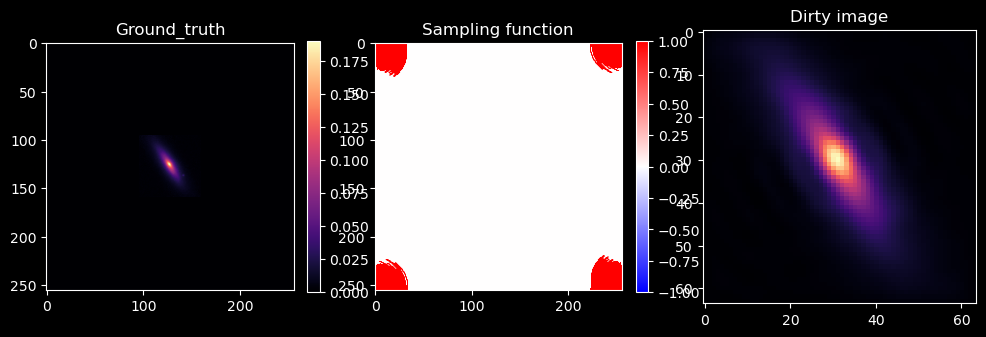

In [55]:
fig, axs = plt.subplots(1, 3, figsize = (3*4, 4))

padded_sample = padding(probes_link_function(prior_samples[0,0]), pad = 96)
im = axs[0].imshow(padded_sample.cpu().numpy(), cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(S.cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)
axs[1].set_title("Sampling function")

dirty_image = dirty_imager(padded_sample, S)

pad = 96
img_size = 64
full_img = img_size + 2* pad
T = (full_img+ img_size)//2 
D = (full_img-img_size)//2 
L = (full_img-img_size)//2 
R = (full_img+ img_size)//2 
axs[2].imshow(dirty_image[D:T, L:R].cpu().numpy(), cmap = "magma")
axs[2].set_title("Dirty image")

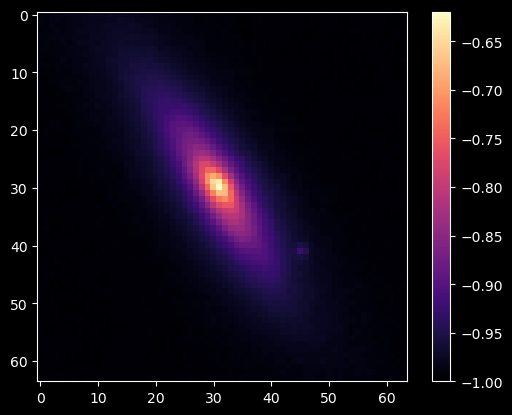

In [59]:
x = prior_samples[0, 0]
plt.imshow(x.cpu(), cmap = "magma")
plt.colorbar()

In [72]:
# Creating a fake observation
pad =  96 # 64 + 2 * 96 = 256 (sampling function for htlup is 256*256)

def noise_padding(x, pad, sigma):
    H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

def model(x, t): 
    x = probes_link_function(x)    
    x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(x_padded)[S]
    print(vis_sampled.shape)
    return complex_to_real(vis_sampled)

def model_to_plot(x, t):
    x = probes_link_function(x)    
    x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(x_padded) * S.to(torch.uint8)
    return complex_to_real(vis_sampled)


In [74]:
t = torch.ones(size = (1,1)).to(device)

sigma_y = 
y = model(x, t) + 
vis_to_plot = model_to_plot(x, t)

torch.Size([3706])


In [71]:
model(x, t)

tensor([ 229.9531, -258.3280,  -26.5578,  ..., -188.0763, -146.1317,
        -180.6773], device='cuda:0')

torch.Size([512, 256])

## Creating an observation and reconstructing the associated ground-truth 

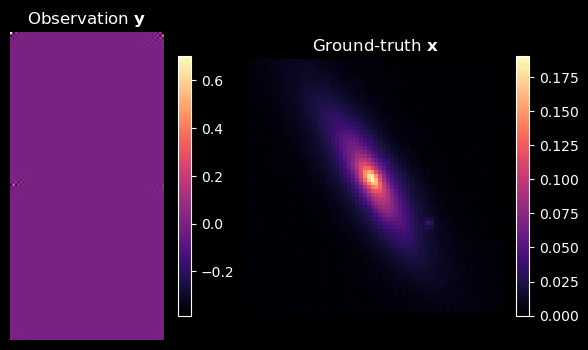

In [28]:

# Creating the observation
sigma_y = 1e-3

# Picking a ground-truth (let's take the most beautiful galaxy)
img_size = prior_samples.shape[-1]
x = probes_link_function(prior_samples[0])
y_complex = ft(x)[S]

# Real representation
y = complex_to_real(y_complex) + sigma_y * torch.randn_like(y_complex.real, device = x.device)


# Plot it to see:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

im = axs[0].imshow(y.reshape(-1, img_size).squeeze().cpu(), cmap = "magma")
plt.colorbar(im, fraction = 0.046)
axs[0].set_title(r"Observation $\mathbf{y}$")

im = axs[1].imshow(x.reshape(img_size, img_size).squeeze().cpu(), cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

In [27]:
torch.randn_like(y_complex)

tensor([[[-0.8821+0.2133j,  0.2963+0.2806j, -1.5133+0.0584j,  ...,
           0.2818+1.7443j,  0.5406+0.2781j, -1.0672+0.3773j],
         [ 1.9743+0.3312j,  1.0889+0.1976j,  1.7837-0.1736j,  ...,
           0.2578+1.1343j,  0.1919-0.8562j,  0.1203-0.3024j],
         [ 0.5600-1.0036j, -0.0478+0.4545j, -0.7606-0.4640j,  ...,
          -0.4196+0.8270j, -0.0021-0.7913j, -0.8718+0.9636j],
         ...,
         [-0.1533+0.3594j,  0.1452-0.4082j, -0.2950+0.0780j,  ...,
          -0.5305-0.1444j,  0.6622+0.2589j, -0.1294-1.3370j],
         [ 1.0445+0.0800j,  0.5746+0.9066j, -0.6117-1.0140j,  ...,
           0.2151+0.6265j,  0.3645-0.3487j,  0.8503+0.2620j],
         [ 0.7605-0.1538j,  0.5910+0.4180j, -0.7129-0.3297j,  ...,
           0.4719+0.1283j,  0.5713+0.0860j,  1.2804+0.9451j]]],
       device='cuda:0')

In [29]:
def model(t, x): 
    x = probes_link_function(x)
    y_complex = ft(x)
    y_hat = complex_to_real(y_complex)
    return y_hat

def log_likelihood(y, x, t, sigma_y, forward_model):
    y_hat = forward_model(t, x) # model prediction
    var = sigma(t, score_model) ** 2 + mu(t, score_model)**2 * sigma_y ** 2 
    log_prob = - 0.5 * torch.sum((y_hat - mu(t, score_model) * y)**2/var)
    return log_prob

def score_likelihood(y, x, t, sigma_y, forward_model): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y, forward_model)), randomness = "different")(x, t)

In [30]:
samples = euler_sampler(
    y = y,
    sigma_y = sigma_y,
    forward_model = model, 
    score_prior = score_model, 
    score_likelihood = score_likelihood, 
    num_samples = 1, 
    num_steps = 500, 
    img_size = (64, 64)
)

t = 0.00 | scale ~ 3.77e-02 | sigma(t) = 1.05e-03 | mu(t) = 1.00e+00: 100%|██████████| 499/499 [00:25<00:00, 19.36it/s]


(-0.5, 63.5, 63.5, -0.5)

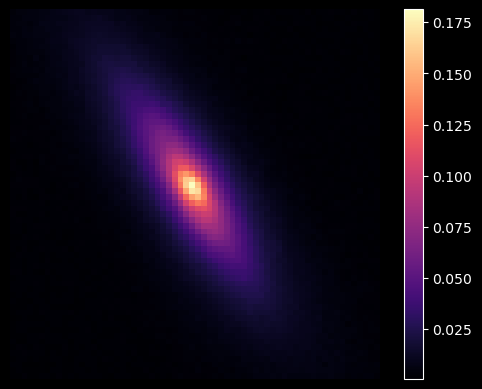

In [31]:
plt.imshow(probes_link_function(samples.squeeze()).cpu(), cmap = "magma")
plt.colorbar()
plt.axis("off")